## Document Scanning using skimage 

Make sure you installed the module locally with `pip install -e .`

Reload extensions, necessary when you make changes to the local module and don't want to restart the kernel every time.

In [41]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


import neccessary dependencies

In [42]:
from util.plot import plot_images
from skimage.io import imread
from skimage.transform import rescale
from skimage.morphology import closing
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage.transform import hough_line
import matplotlib.pyplot as plt
import numpy as np

Read the image and scale it down to reduce computational expences

In [43]:
preferred_min_size = 256
img_path = "../images/example_0.jpg"

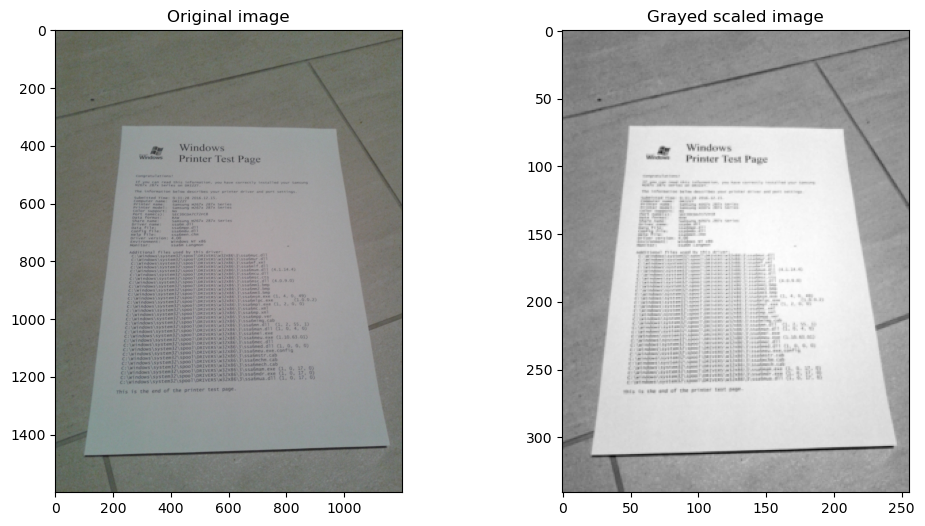

In [44]:
img = imread(img_path)

min_side = np.min(img.shape[:2])
scaling_factor = preferred_min_size / min_side

working_img = rescale(img, scaling_factor, channel_axis=2)
working_img = rgb2gray(working_img[:, :, :3])

_ = plot_images([(img, "Original image"), (working_img, "Grayed scaled image", plt.cm.gray)], figsize=(12,6))

Use closing and gaussian blur as preprocessing steps to remove noise and thins like text

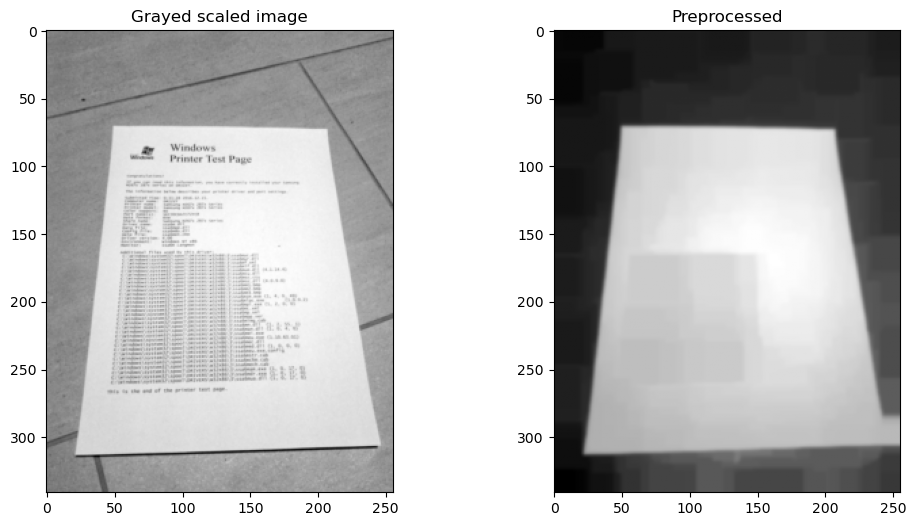

In [45]:
preprocess_img = closing(working_img, footprint=[(np.ones((27, 1)), 1), (np.ones((1, 27)), 1)])
preprocess_img = gaussian(preprocess_img, sigma=1.2)

_ = plot_images([(working_img, "Grayed scaled image", plt.cm.gray), (preprocess_img, "Preprocessed", plt.cm.gray)], figsize=(12,6))

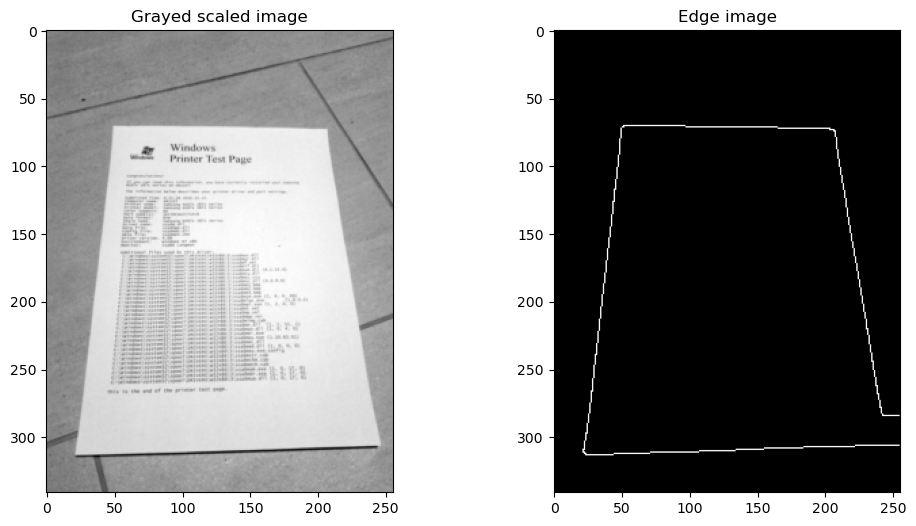

In [46]:
edge_image = canny(preprocess_img)

_ = plot_images([(working_img, "Grayed scaled image", plt.cm.gray), (edge_image, "Edge image", plt.cm.gray)], figsize=(12,6))

With the now final preprocessed image, 
1. use hough transform to find lines which would correspond to the edges of the document, in the image.
2. find the corners by calculating the intersection points of the lines
3. if less then 4 corners are found, redo step 1 but allow for one more line to be found
4. if more then 4 corners are found, choose the 4 corners that are closest to be in a 90° angle 

In [47]:
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(edge_image, theta=tested_angles)

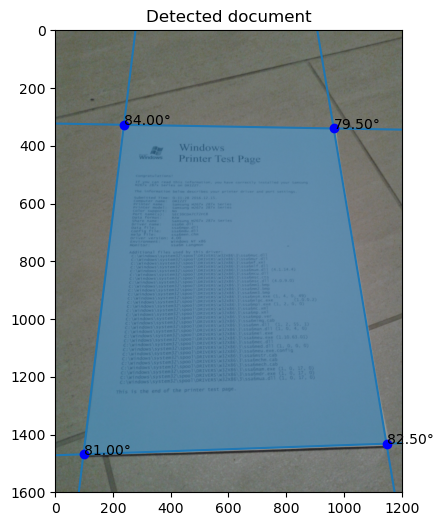

In [48]:
from util.geometry import Intersection, rescale_point
from corner_detection import (
    find_corners_from_hough_space,
    find_intersections,
    detect_corners,
)


max_peaks = 4

corners, lines = find_corners_from_hough_space(
    h,
    theta,
    d,
    max_peaks=max_peaks,
    img_shape=working_img.shape,
    epsilon=0.1,
    threshold_percentage=0.2,
)

if corners is None:
    print("Not Enough corners could be found, document can't be detected")
    raise ValueError()

# undo scaling
[corner.point.rescale(working_img.shape, img.shape[:-1]) for corner in corners]


# find the best 4 corners (closest to 90° angles)


# if len(corners) > 4:


#     ord = np.argsort(np.abs(90 - np.abs(angles)))


#     corners = np.array(corners)[ord][:4]


#     angles = np.array(angles)[ord][:4]


corner_positions = np.array([corner.point.coords for corner in corners])


# centroid = np.mean(corner_positions, axis=0)


# sort the corners in counter clockwise order starting form the 3. Quadrant


# since matplotlib coords start in the topleft corner and the y axis is positive downwards the Quadrants are mirrored horizontally


# centroid_angles = np.arctan2(corners[:,1] - centroid[1], corners[:,0] - centroid[0])


# corners = np.array(corners)[np.argsort(centroid_angles)]


# angles = np.array(angles)[np.argsort(centroid_angles)]


fig, ax = plot_images(
    [(img, "Detected document", plt.cm.gray)], figsize=(12, 6), limit_axis=True
)


ax[0].fill(*zip(*corner_positions), fill="b", alpha=0.5, linewidth=0)


for line in lines:
    x0, y0 = rescale_point((line.x, line.y), working_img.shape, img.shape[:-1])
    ax[0].axline((x0, y0), slope=line.m)


for corner in corners:
    ax[0].text(corner.point.x, corner.point.y, f"{abs(corner.angle):.2f}°")
    ax[0].plot(corner.point.x, corner.point.y, "bo")

#convert corners to list of points for further use
corners = np.array([corner.point.coords for corner in corners])

Define width and height of the warped image

In [49]:
from util.geometry import euclidean_distance

# get the average size of the parallel sides of the document
horizontal_side_avg = int(np.average([euclidean_distance(corners[0], corners[1]), euclidean_distance(corners[2], corners[3])]))
vertical_side_avg = int(np.average([euclidean_distance(corners[0], corners[3]), euclidean_distance(corners[1], corners[2])]))

# define the shortest side as the width and the larger side as the height
sides = [horizontal_side_avg, vertical_side_avg]
shortest_idx = np.argmin(sides)
width = sides[shortest_idx]
height = max(sides)

# if the vertical side is the smallest the document is orientated in landscape and needs to be rotated 
in_landscape_position = shortest_idx == 1
print(f"In {'landscape' if in_landscape_position else 'portrait'} position")

In portrait position


Using the orientation (landscape or portrait) of the document, mark each corner with the fitting position. Right now it can't correctly a document that is "upside down" in portrait or landscape orientation

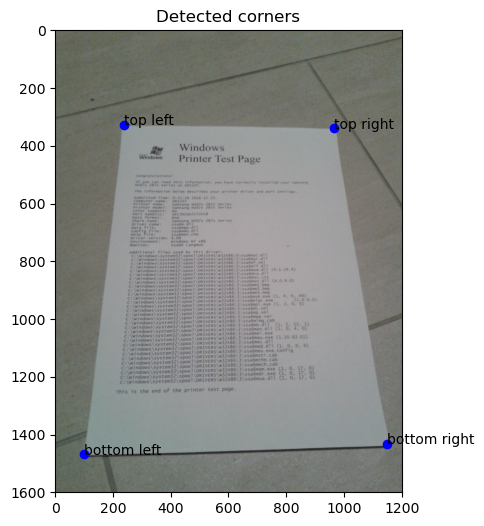

In [ ]:
# specify the order starting from top left counterclockwise order
corner_order = [1, 0, 3, 2] if in_landscape_position else [0, 3, 2, 1]

fig, ax = plot_images(
    [(img, "Detected corners", plt.cm.gray)], figsize=(12, 6), limit_axis=True
)

# order is bottom left counter clockwise but since the image positive y axis is facing downwards topleft is the first point here
ccw_corners = corners[corner_order]
labels = ["top left", "bottom left", "bottom right", "top right"]
for i, ((x, y), label) in enumerate(list(zip(ccw_corners, labels))):
    ax[0].text(x, y, label)
    ax[0].plot(x, y, "bo")

Warp the image to a top down perspective

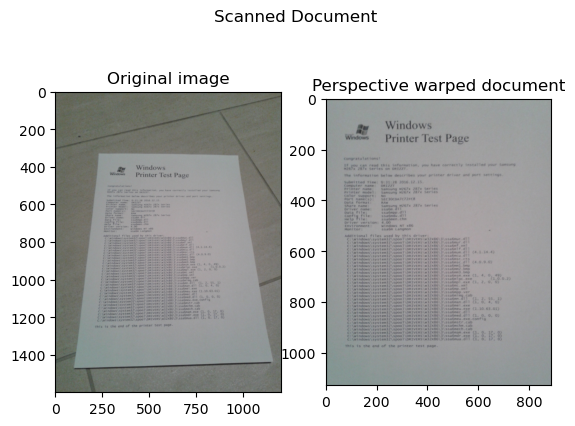

In [51]:
from skimage.transform import ProjectiveTransform, warp

# 0 0 is top left origin
src = np.array([[0,0], [0, height], [width, height], [width, 0]])
dst = ccw_corners.copy()


projectiveTransform = ProjectiveTransform()
projectiveTransform.estimate(src, dst)
warped = warp(img, projectiveTransform, output_shape=(height, width), mode="constant", cval=1)
warped = (warped * 255).astype(np.uint8)

fig, ax = plot_images([(img, "Original image"), (warped, "Perspective warped document")], title="Scanned Document")

In [52]:
from skimage.io import imsave
from os import path
from pathlib import Path

out_dir = Path("../out")

imsave(out_dir / f"{path.basename(img_path).split(".")[0]}_scanned_document.png", warped)